# Running a Model in Stochastic Mode

[CompartmentalModel](/api/model.html) runs are deterministic, because the ODE solvers we use are deterministic. For a given set of compartments and (deterministic) flows, the outputs will always be the same.

These deterministic models work better in scenarios where there is a large population and the law of large numbers has a strong effect.

Sometimes, however, we want to simulate scenarios where some compartments have very low numbers of people. For example, we might consider a case where only 1-3 people are infected/infectious. The the deterministic ODE-based approach can produce results such as "half a person is infected" and does not capture the underlying randomness of this scenario. To address this issue, there is a stochastic approach that can be used instead of the deterministic, ODE-based appproach. You can read the details of how it is calulated [here](https://autumn-files.s3-ap-southeast-2.amazonaws.com/Switching_to_stochastic_mode.pdf).

To summarise the linked explanation:

- Flow rates are interpreted as probabilities
- Transition and exit flows are sampled from a multinomial distribution
- Entry flows are sampled from a Poisson distribution

To achieve this practically, you can run the model with `model.run_stochastic()` instead of `model.run()`.

Here is an example:

In [1]:
from summer import CompartmentalModel


def build_model(timestep, infectious_seed) -> CompartmentalModel:
    """
    Returns the SIR model, ready to run.
    """
    model = CompartmentalModel(
        times=[1990, 2020],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=timestep,
    )
    # Add 1000 susceptible people + some infectious people.
    model.set_initial_population(distribution={"S": 1000, "I": infectious_seed})

    # Add flows between the compartments.
    # Susceptible people get infected - contact rate is an arbitrary number.
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")
    # Infectious people take 2 years, on average, to recover.
    model.add_sojourn_flow(name="recovery", sojourn_time=2, source="I", dest="R")
    # Add an infection-specific death flow to the I compartment.
    model.add_death_flow(name="infection_death", death_rate=0.05, source="I")
    return model

## Runing the stochastic version side by side with the ODE-based version

Here you can see the results of a stochastic model compared to a ODE-based model.

A technical point to note: 

- The ODE-based model **does not** use the `timestep` parameter to perform the integration, rather it uses an adaptive timestep. The timestep is only used for interpolating the results. So the results are not very sensitive to changes in the requested timestep.
- The stochastic method **does** use the `timestep` parameter for running the integration, and the results are sensitive to the changes in the timestep.

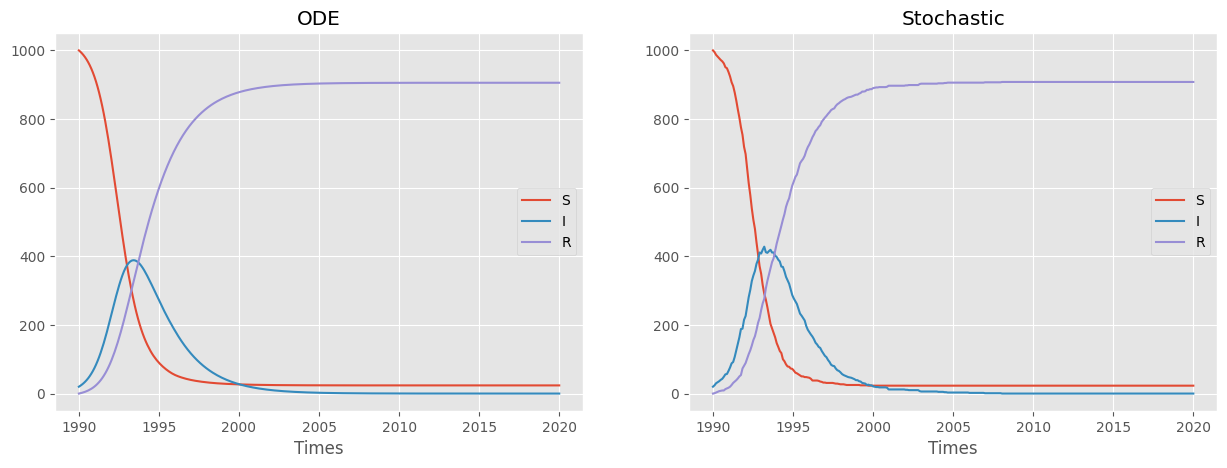

In [2]:
from matplotlib import pyplot

# Build and run the deterministic, ODE-based model.
model_ode = build_model(timestep=0.1, infectious_seed=20)
model_ode.run()

# Build and run the stochastic model.
model_st = build_model(timestep=0.1, infectious_seed=20)
model_st.run_stochastic()

# Plot the results for both.
pyplot.style.use("ggplot")
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 5), dpi=100)
for ax, model, name in [(ax1, model_ode, "ODE"), (ax2, model_st, "Stochastic")]:
    values = {str(c): v for c, v in zip(model.compartments, model.outputs.T)}
    ax.set_title(name)
    ax.set_xlabel("Times")
    for plot_vals in values.values():
        ax.plot(model.times, plot_vals)
        
    ax.legend(list(values.keys()), loc="center right")

## Simulating disease extinction with the stochastic model

Because the stochastic model deals with a discrete, rather than continuous, number of people, we can simulate the number of infected people going to 0, rather than 1/25th of a person. 

In [3]:
NUM_TRIALS = 500

def simulate_extinction(timestep, infectious_seed):
    # Create a model.
    model = build_model(timestep, infectious_seed)

    # Run the model many times
    extinct_times = []  # Track when the number of infections goes to zero.
    infected_timeseries = []  # Track number of infections over time. 
    for i in range(NUM_TRIALS):
        # Run the model
        model.run_stochastic()
        infected = model.outputs[:, 1].T
        infected_timeseries.append([model.times, infected])
        # Determine when infections went to zero. 
        for s,t in zip(infected, model.times):
            if s == 0:
                extinct_times.append(t)
                break

    # Plot timeseries.
    fig, ax = pyplot.subplots(1, 1, figsize=(15, 5), dpi=100)
    ax.set_title("Number of infected people")
    ax.set_xlabel("Time")
    for t, v in infected_timeseries:           
        ax.plot(t, v, alpha=0.3)

    # Plot number of simulated extinctions per year.
    fig, ax = pyplot.subplots(1, 1, figsize=(15, 5), dpi=100)
    ax.set_title("Number of extinctions")
    ax.set_xlabel("Time")
    ax.hist(extinct_times, bins=range(1990, 2026))


Here we simulate 1000 trials where we started with 1 infected person, who could die or recover before they infect anyone else. As you can see below, the disease dies out in ~20-30% of cases.

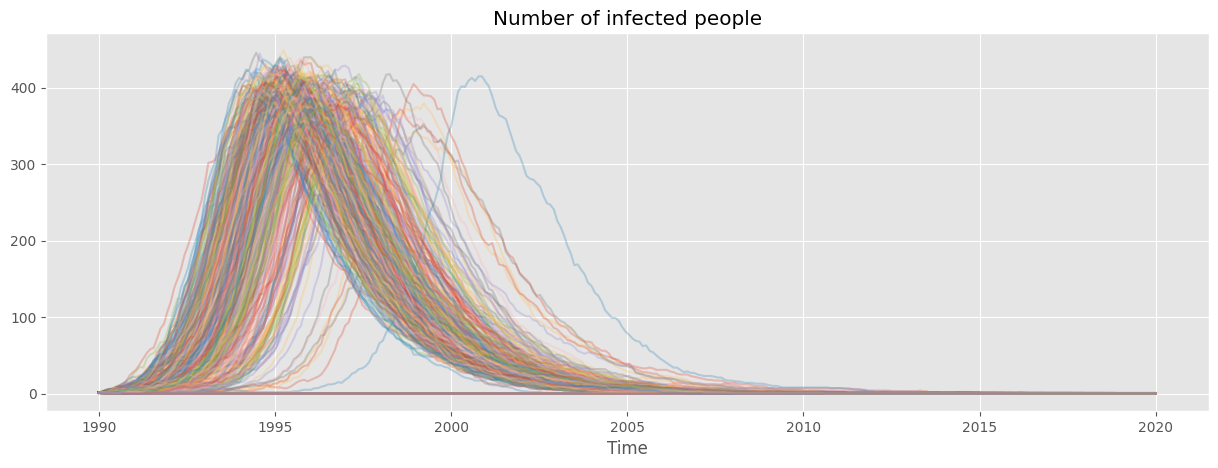

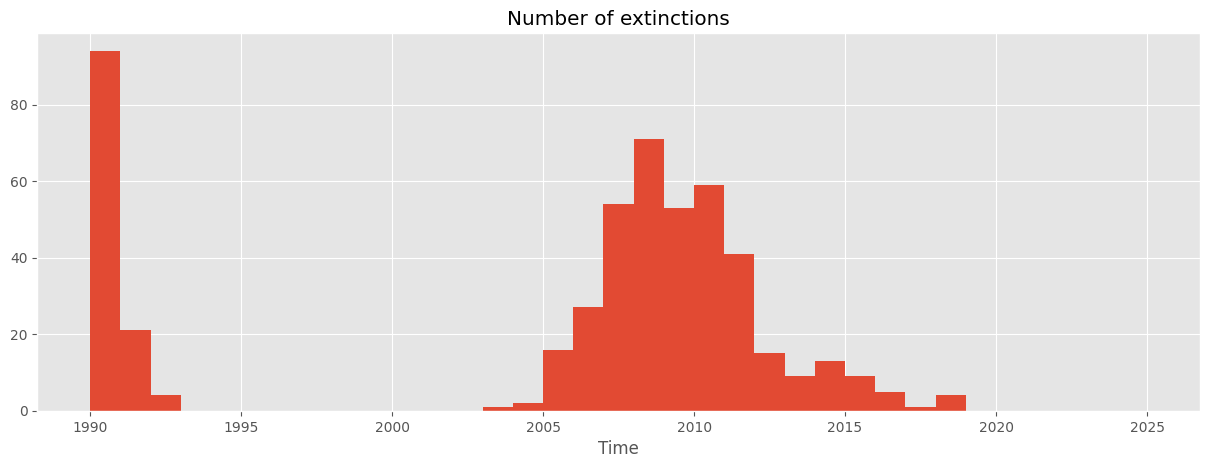

In [4]:
simulate_extinction(timestep=0.1, infectious_seed=1)

Note that increasing the chosen timestep will reduce the probability that the disease will die out.

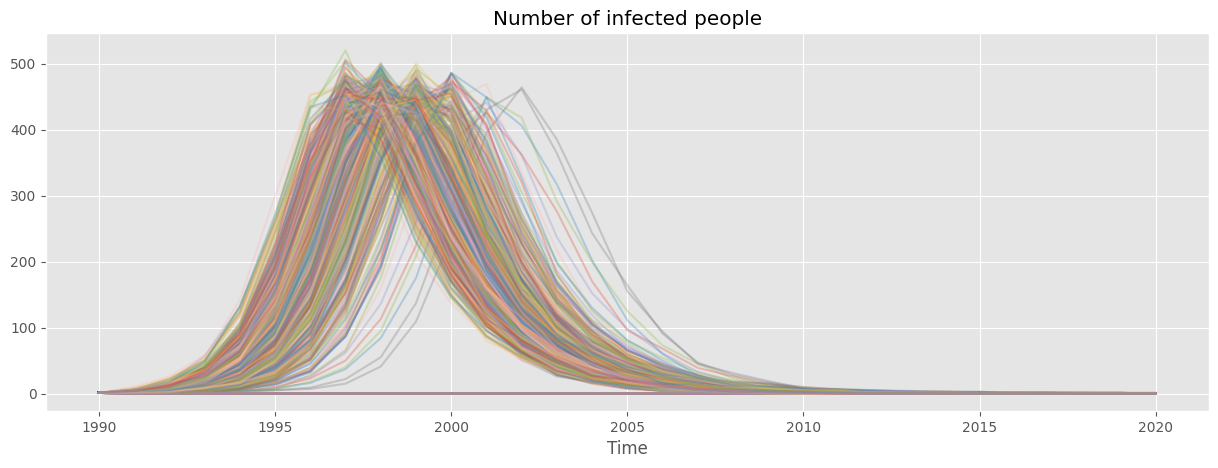

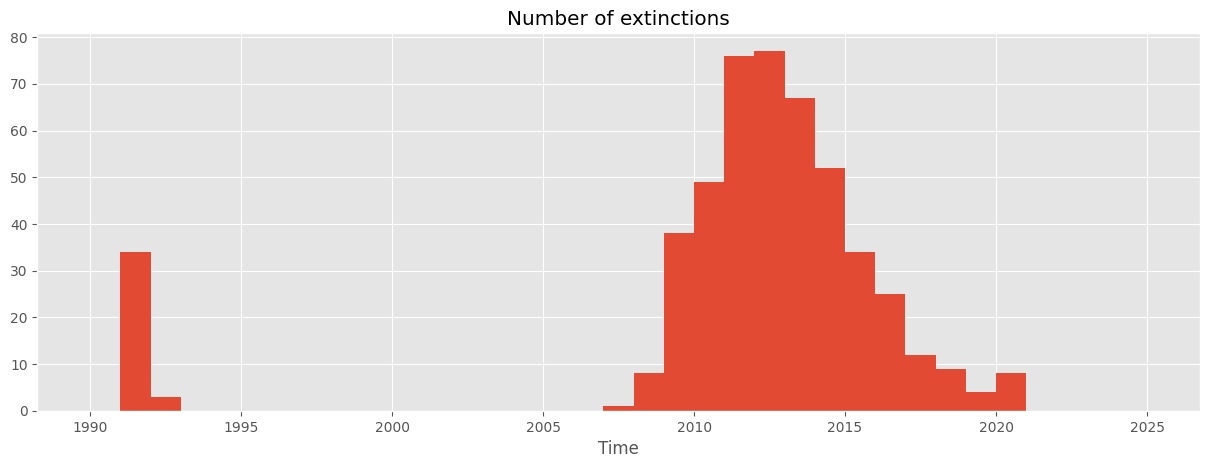

In [5]:
simulate_extinction(timestep=1, infectious_seed=1)

Increasing the number of initially infectious people will also reduce the chance that the disease will die out.

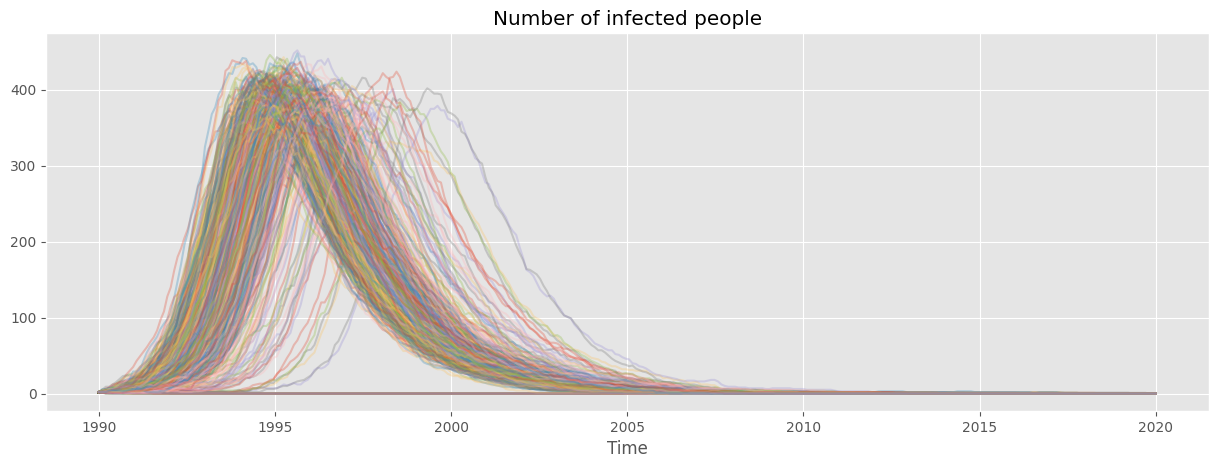

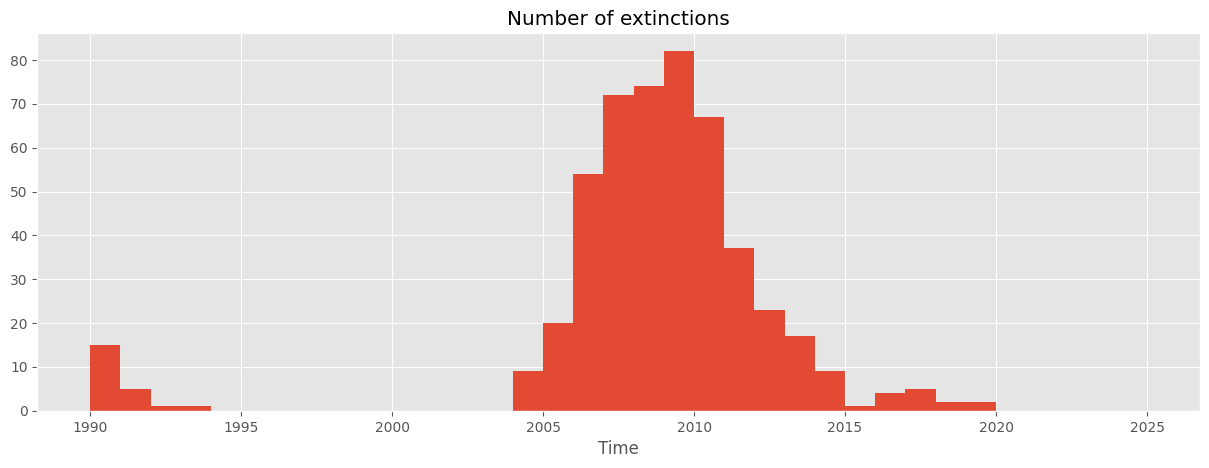

In [6]:
simulate_extinction(timestep=0.1, infectious_seed=2)